In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"

import jax

device_id = 9

device = jax.devices()[device_id]
jax.config.update("jax_default_device", device)

import jax.numpy as jnp

jnp.zeros(10)

2025-04-30 10:19:37.722677: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 0 and 9; status: INTERNAL: failed to enable peer access from 0x7f482c8f91c0 to 0x7f48348f80a0: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2025-04-30 10:19:37.726859: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 1 and 9; status: INTERNAL: failed to enable peer access from 0x7f484c8f87a0 to 0x7f48348f80a0: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2025-04-30 10:19:37.729221: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 2 and 9; status: INTERNAL: failed to enable peer access from 0x7f48408f80b0 to 0x7f48348f80a0: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2025-04-30 10:19:37.731192: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 3 and 9; status: INTERNAL: failed to enable peer access from 0x7f48

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [2]:
import logging

import joblib
import numpy as np
import pandas as pd
from track_linearization import get_linearized_position

from non_local_detector.environment import Environment

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")



def load_data():
    try:
        path = "/Users/edeno/Downloads/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)
    except FileNotFoundError:
        path = "/cumulus/edeno/non_local_paper/notebooks/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)

    return is_ripple, spikes, position, speed, env, time, position2D


def load_data_alison(path="/Users/edeno/Downloads/"):
    animal_date_epoch = "j1620210710_02_r1"
    position_info = pd.read_pickle(path + f"{animal_date_epoch}_position_info.pkl")
    spike_times = joblib.load(path + f"{animal_date_epoch}_HPC_spike_times.pkl")
    track_graph = joblib.load(path + f"{animal_date_epoch}_track_graph.pkl")
    linear_edge_order = joblib.load(path + f"{animal_date_epoch}_linear_edge_order.pkl")
    linear_edge_spacing = joblib.load(
        path + f"{animal_date_epoch}_linear_edge_spacing.pkl"
    )

    return (
        position_info,
        spike_times,
        track_graph,
        linear_edge_order,
        linear_edge_spacing,
    )


position_info, spike_times, track_graph, edge_order, edge_spacing = load_data_alison(path="/cumulus/edeno/non_local_paper/notebooks/")
edge_spacing = 1.5
time = position_info.index

speed = position_info["head_speed"].to_numpy()
position2D = position_info[["head_position_x", "head_position_y"]].to_numpy()
env = Environment(
    place_bin_size=1.5,
    track_graph=track_graph,
    edge_order=edge_order,
    edge_spacing=edge_spacing,
)
position = get_linearized_position(
    position2D,
    track_graph=track_graph,
    edge_order=edge_order,
    edge_spacing=edge_spacing,
).linear_position.to_numpy().squeeze()

/cumulus/edeno/non_local_detector/src/non_local_detector/likelihoods/clusterless_kde.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# is_ripple, spikes, position, speed, env, time, position2D = load_data()
# spikes = (spikes > 0).astype(int)
# spike_times = [time[spike.astype(bool)] for spike in spikes.T]


# sampling_frequency = 500
# time_range = (time[0], time[-1] + (1 / sampling_frequency))

# n_time_bins = (
#     int((time_range[-1] - time_range[0]) * sampling_frequency) + 1
# )
# t = time_range[0] + np.arange(n_time_bins) / sampling_frequency

# np.allclose(t, time)

In [3]:
from non_local_detector import NonLocalSortedSpikesDetector

detector_noEM = NonLocalSortedSpikesDetector(
    environments=env,
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": np.sqrt(12.5),
        "block_size": int(2**12),
    },
).fit(time, position2D, spike_times)

30-Apr-25 10:33:44 Fitting initial conditions...
30-Apr-25 10:33:44 Fitting discrete state transition
30-Apr-25 10:33:44 Fitting continuous state transition...
30-Apr-25 10:33:46 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

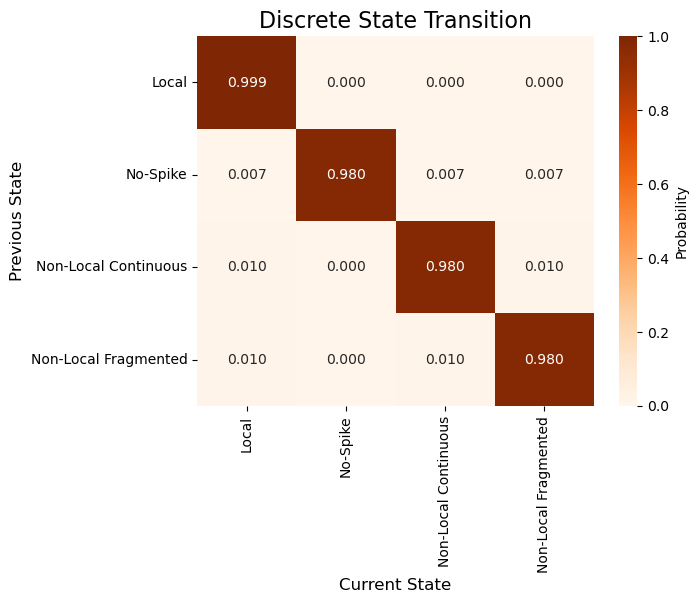

In [4]:
detector_noEM.plot_discrete_state_transition()

In [5]:
results_noEM = detector_noEM.predict(spike_times, time, position2D, time)
results_noEM

30-Apr-25 10:43:39 Computing posterior...
30-Apr-25 10:43:39 Computing log likelihood...


Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

<xarray.Dataset>
Dimensions:                      (time: 709321, state_bins: 680, states: 4,
                                  state_ind: 680)
Coordinates:
  * time                         (time) float64 1.626e+09 ... 1.626e+09
  * state_bins                   (state_bins) object MultiIndex
  * state                        (state_bins) object 'Local' ... 'Non-Local F...
  * position                     (state_bins) float64 nan nan ... 498.3 499.8
  * state_ind                    (state_ind) int64 0 1 2 2 2 2 2 ... 3 3 3 3 3 3
  * states                       (states) <U20 'Local' ... 'Non-Local Fragmen...
    environments                 (states) <U1 '' '' '' ''
    encoding_groups              (states) int64 0 0 0 0
Data variables:
    acausal_posterior            (time, state_bins) float32 1.0 ... 0.001005
    acausal_state_probabilities  (time, states) float32 1.0 2.422e-17 ... 0.1938
Attributes:
    marginal_log_likelihoods:  -3630415.5

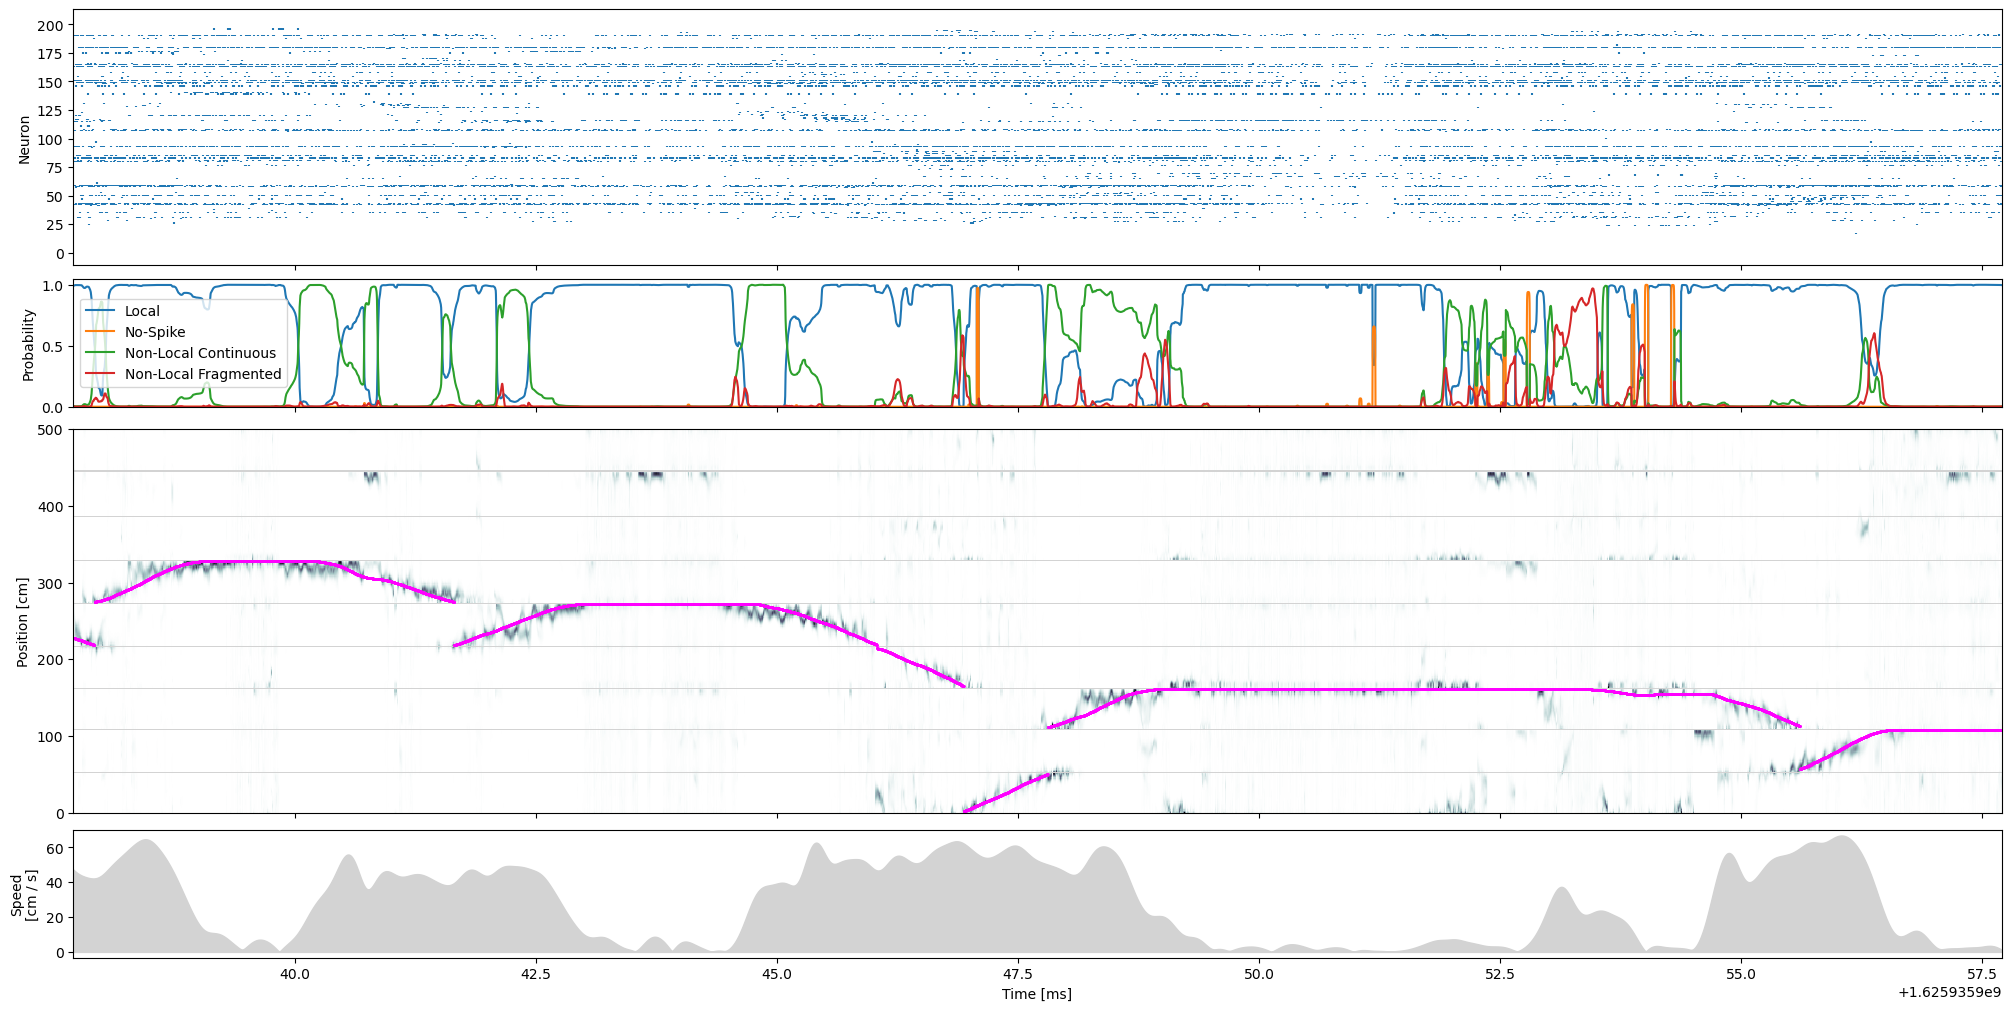

In [6]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    time,
    position,
    spike_times,
    speed,
    detector_noEM,
    results_noEM,
    time_slice=slice(time[90_000], time[100_000]),
    figsize=(20, 10),
)

In [7]:
detector = NonLocalSortedSpikesDetector(
    environments=env,
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": np.sqrt(12.5),
        "block_size": int(2**12),
    },
)
results = detector.estimate_parameters(
    position_time=time,
    position=position2D,
    spike_times=spike_times,
    time=time,
)

30-Apr-25 10:48:45 Fitting initial conditions...
30-Apr-25 10:48:45 Fitting discrete state transition
30-Apr-25 10:48:45 Fitting continuous state transition...
30-Apr-25 10:48:47 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:48:52 Expectation step...
30-Apr-25 10:48:52 Computing posterior...
30-Apr-25 10:48:52 Computing log likelihood...


Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:50:27 Maximization step...
30-Apr-25 10:50:27 Estimating encoding model...
30-Apr-25 10:50:27 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:50:32 Computing stats..
30-Apr-25 10:50:32 iteration 1, likelihood: -3630415.5
30-Apr-25 10:50:32 Expectation step...
30-Apr-25 10:50:32 Computing posterior...
30-Apr-25 10:50:32 Computing log likelihood...


Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:52:06 Maximization step...
30-Apr-25 10:52:06 Estimating encoding model...
30-Apr-25 10:52:06 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:52:11 Computing stats..
30-Apr-25 10:52:11 iteration 2, likelihood: -3605557.75, change: 24857.75
30-Apr-25 10:52:11 Expectation step...
30-Apr-25 10:52:11 Computing posterior...
30-Apr-25 10:52:11 Computing log likelihood...


Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:53:44 Maximization step...
30-Apr-25 10:53:44 Estimating encoding model...
30-Apr-25 10:53:44 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:53:49 Computing stats..
30-Apr-25 10:53:49 iteration 3, likelihood: -3598665.5, change: 6892.25
30-Apr-25 10:53:49 Expectation step...
30-Apr-25 10:53:49 Computing posterior...
30-Apr-25 10:53:49 Computing log likelihood...


Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:55:24 Maximization step...
30-Apr-25 10:55:24 Estimating encoding model...
30-Apr-25 10:55:24 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:55:29 Computing stats..
30-Apr-25 10:55:29 iteration 4, likelihood: -3597928.0, change: 737.5
30-Apr-25 10:55:29 Expectation step...
30-Apr-25 10:55:29 Computing posterior...
30-Apr-25 10:55:29 Computing log likelihood...


Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:57:02 Maximization step...
30-Apr-25 10:57:02 Estimating encoding model...
30-Apr-25 10:57:02 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:57:06 Computing stats..
30-Apr-25 10:57:06 iteration 5, likelihood: -3597191.75, change: 736.25
30-Apr-25 10:57:06 Expectation step...
30-Apr-25 10:57:06 Computing posterior...
30-Apr-25 10:57:06 Computing log likelihood...


Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:58:40 Maximization step...
30-Apr-25 10:58:40 Estimating encoding model...
30-Apr-25 10:58:40 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 10:58:45 Computing stats..
30-Apr-25 10:58:45 iteration 6, likelihood: -3593021.0, change: 4170.75
30-Apr-25 10:58:45 Expectation step...
30-Apr-25 10:58:45 Computing posterior...
30-Apr-25 10:58:45 Computing log likelihood...


Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 11:00:18 Maximization step...
30-Apr-25 11:00:18 Estimating encoding model...
30-Apr-25 11:00:18 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 11:00:23 Computing stats..
30-Apr-25 11:00:23 iteration 7, likelihood: -3591163.25, change: 1857.75
30-Apr-25 11:00:23 Expectation step...
30-Apr-25 11:00:23 Computing posterior...
30-Apr-25 11:00:23 Computing log likelihood...


Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 11:01:57 Maximization step...
30-Apr-25 11:01:57 Estimating encoding model...
30-Apr-25 11:01:57 Fitting place fields...


Encoding models:   0%|          | 0/203 [00:00<?, ?cell/s]

30-Apr-25 11:02:01 Computing stats..
30-Apr-25 11:02:01 iteration 8, likelihood: -3591183.5, change: -20.25


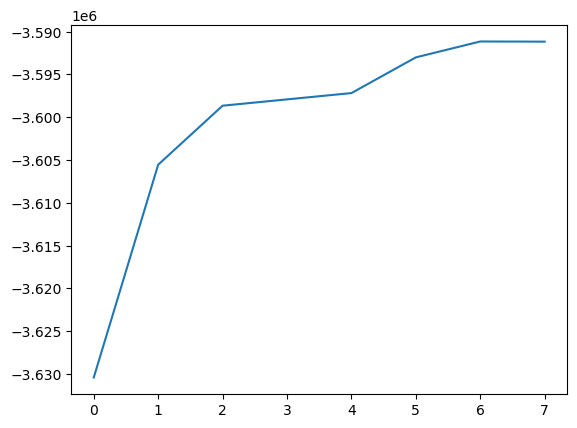

In [8]:
import matplotlib.pyplot as plt

plt.plot(results.marginal_log_likelihoods)

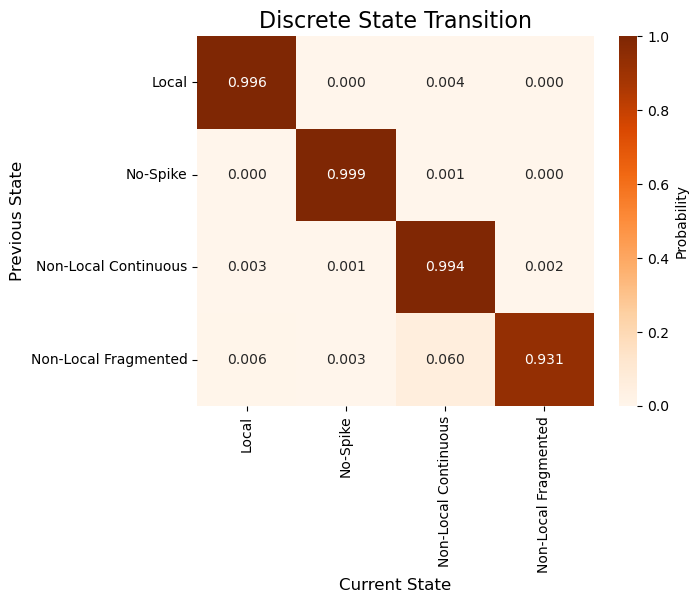

In [10]:
detector.plot_discrete_state_transition()

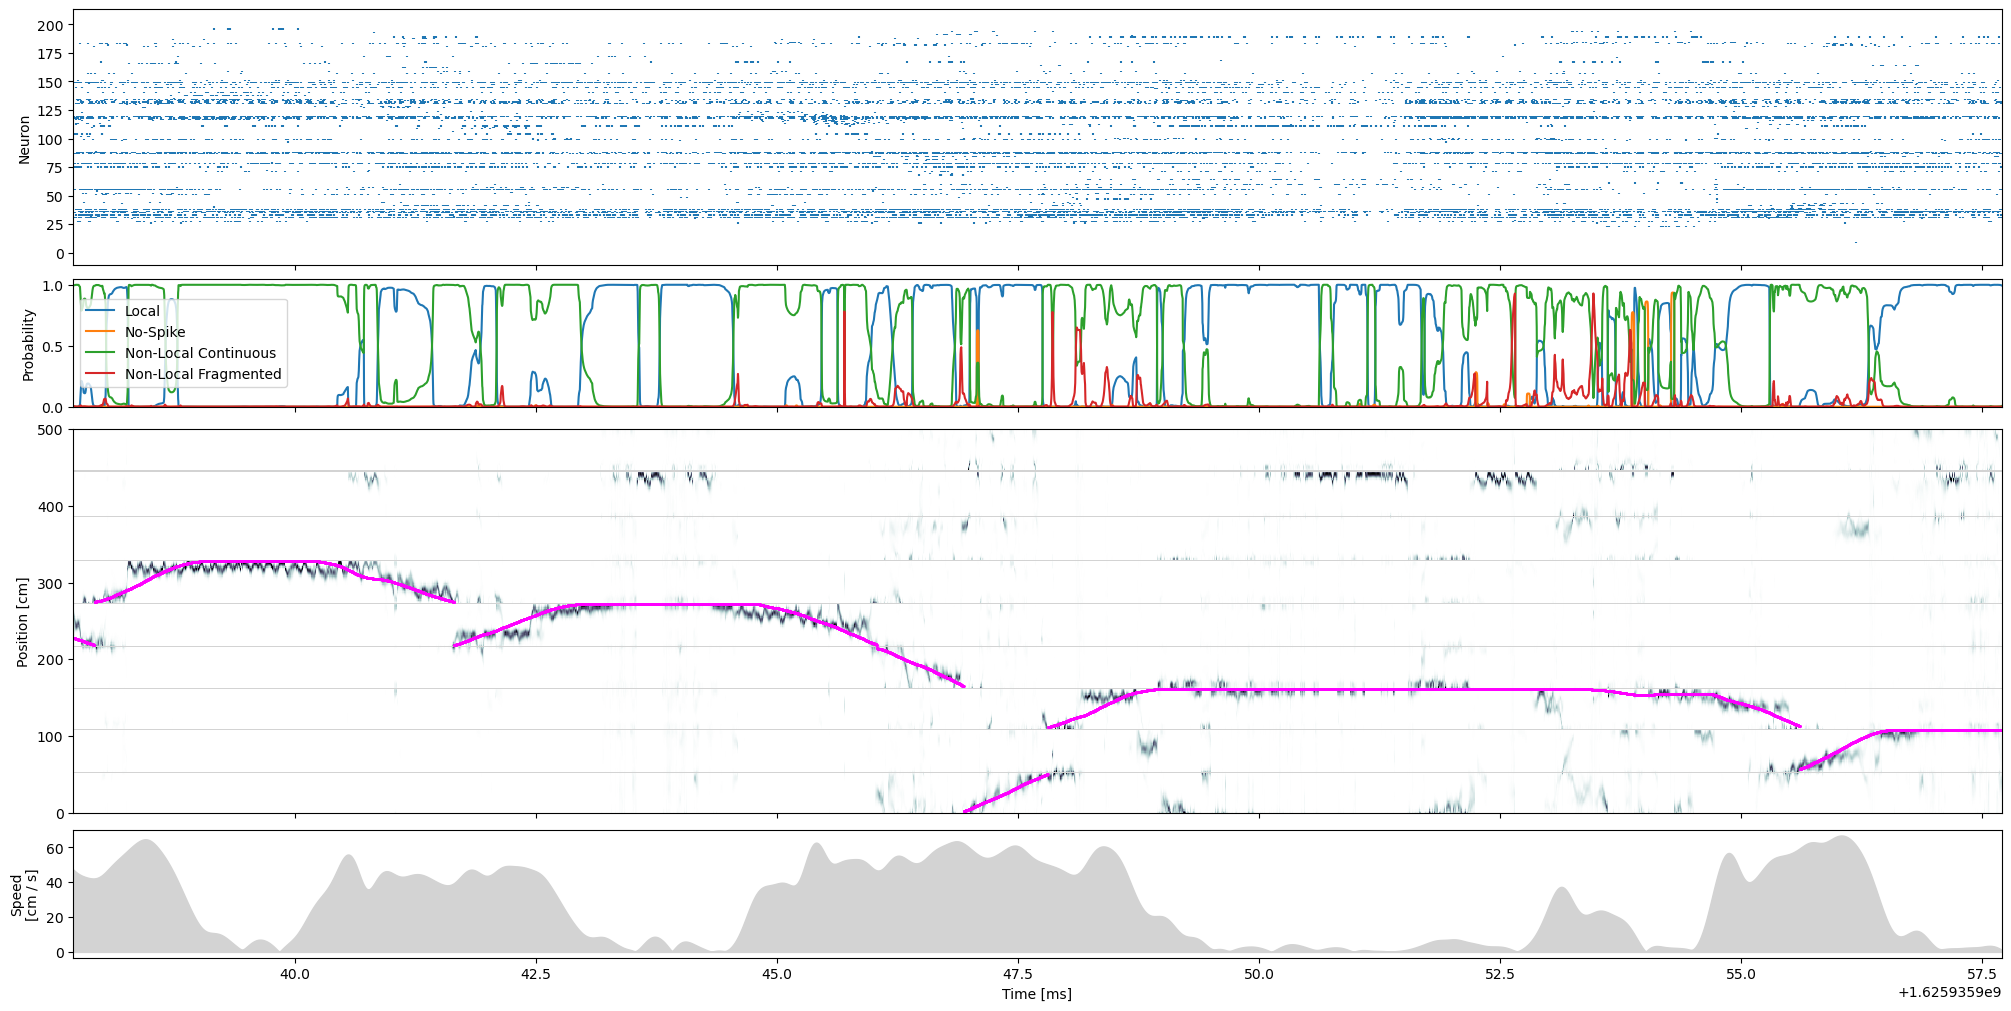

In [9]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    time,
    position,
    spike_times,
    speed,
    detector,
    results,
    time_slice=slice(time[90_000], time[100_000]),
    figsize=(20, 10),
)

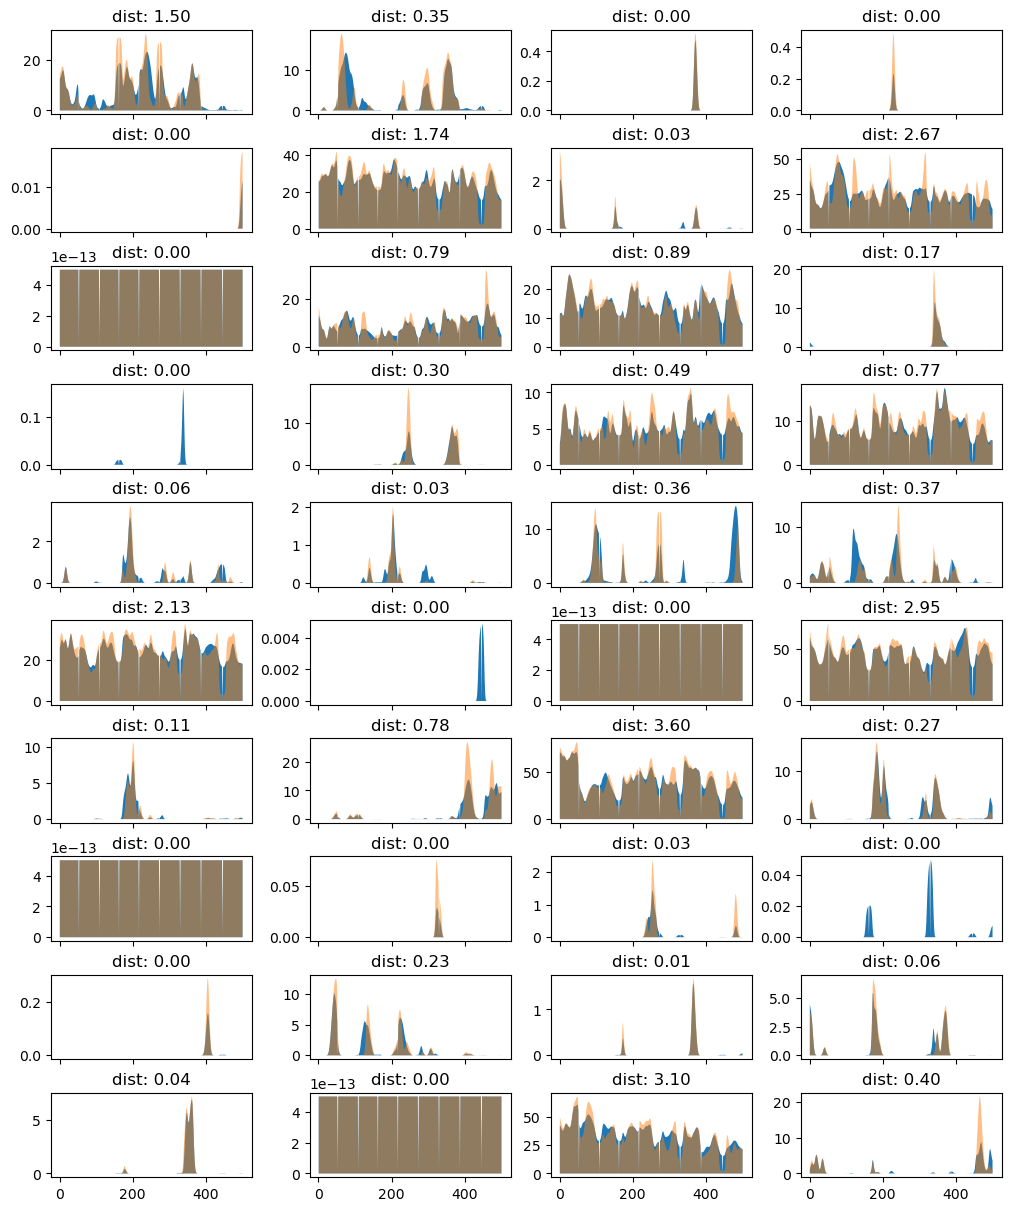

In [16]:
import scipy.stats

initial_place_fields = detector_noEM.encoding_model_[('', 0)]["place_fields"]
final_place_fields = detector.encoding_model_[('', 0)]["place_fields"]

fig, axes = plt.subplots(
    10, 4, figsize=(10, 12), sharex=True, sharey=False, constrained_layout=True
)

for neuron_ind, ax in enumerate(axes.flat):
    ax.fill_between(
        env.place_bin_centers_.squeeze(),
        initial_place_fields[neuron_ind] * 500,
    )
    ax.fill_between(
        env.place_bin_centers_.squeeze(),
        final_place_fields[neuron_ind] * 500,
        alpha=0.5,
    )
    dist = scipy.stats.wasserstein_distance(
        initial_place_fields[neuron_ind] * 500,
        final_place_fields[neuron_ind] * 500,
    )
    ax.set_title(f"dist: {dist:.2f}")